In [1]:
CELL_TYPE = 'DC'
N_SPLITS: int = 5
N_TRIALS: int = 50
RUN_NAME: str = "studyID"

In [2]:
# Parameters
CELL_TYPE = "T_CD4_Naive"


In [3]:
if RUN_NAME != "":
    RUN_NAME = RUN_NAME + "_"

In [4]:
import os
import sys
#from pyprojroot.here import here

import pandas as pd
import anndata as ad
import numpy as np
import math
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

import optuna

import joblib
import pickle
import datetime

import collections

import xgboost
from sklearn.preprocessing import LabelEncoder

import scipy.sparse as ssp
import joblib

from pyprojroot import here

from dotenv import load_dotenv

In [5]:
assert load_dotenv()

def here(fpath):
    return os.path.join(BUCKET_DIRPATH, fpath)

In [6]:
target_y = 'studyID'

# LOAD DATASET

In [7]:
adata = ad.read_h5ad(
    str(here(f'03_downstream_analysis/08_gene_importance/data/{CELL_TYPE}_adataMerged_SPECTRAgenes.log1p.h5ad')),
    backed='r',
    chunk_size=25000
)

In [8]:
adata.obs

,studyID,libraryID,sampleID,chemistry,disease,sex,binned_age,Level1,Level2
cellID,,,,,,,,,
Zhang2023_L011_P190808_T0_AAACCTGAGGGCTCTC,Zhang2023,Zhang2023_L011,Zhang2023_P190808_T0,5_GEX_V1,HBV,female,51-60,T_CD4_Naive,T_CD4_Naive
Zhang2023_L011_P190808_T0_AAACCTGGTCCCTTGT,Zhang2023,Zhang2023_L011,Zhang2023_P190808_T0,5_GEX_V1,HBV,female,51-60,T_CD4_Naive,T_CD4_Naive
Zhang2023_L011_P190808_T0_AAACGGGCAAGGACTG,Zhang2023,Zhang2023_L011,Zhang2023_P190808_T0,5_GEX_V1,HBV,female,51-60,T_CD4_Naive,T_CD4_Naive
Zhang2023_L011_P190808_T0_AAACGGGTCGGGAGTA,Zhang2023,Zhang2023_L011,Zhang2023_P190808_T0,5_GEX_V1,HBV,female,51-60,T_CD4_Naive,T_CD4_Naive
Zhang2023_L011_P190808_T0_AAAGATGAGCAACGGT,Zhang2023,Zhang2023_L011,Zhang2023_P190808_T0,5_GEX_V1,HBV,female,51-60,T_CD4_Naive,T_CD4_Naive
...,...,...,...,...,...,...,...,...,...
Terekhova2023_L025_FB02_T0_TTTACTGCAGTGGAGT,Terekhova2023,Terekhova2023_L025,Terekhova2023_FB02_T0,5_GEX_V2,healthy,female,31-40,T_CD4_Naive,T_CD4_Naive
Terekhova2023_L025_FB02_T0_TTTACTGTCTCCGGTT,Terekhova2023,Terekhova2023_L025,Terekhova2023_FB02_T0,5_GEX_V2,healthy,female,31-40,T_CD4_Naive,T_CD4_Naive
Terekhova2023_L025_FB02_T0_TTTATGCTCCACGACG,Terekhova2023,Terekhova2023_L025,Terekhova2023_FB02_T0,5_GEX_V2,healthy,female,31-40,T_CD4_Naive,T_CD4_Naive


# EXTRACT INDEXES FOR DATA SPLITTING (STRATIFIED BY DISEASE, GROUPED BY PATIENT)

# EXTRACT CELL COUNTS PER SPLIT (TO MAKE SURE THAT RATIOS RESEMBLE 70:20:10)

In [9]:
all_idxs = np.arange(adata.obs.shape[0])
left_out_splits = [s[1] for s in StratifiedGroupKFold(n_splits=N_SPLITS).split(all_idxs, adata.obs[target_y], adata.obs.sampleID)]

min_stats = []
for val_fold_idx, test_fold_idx in product(range(N_SPLITS), range(1,N_SPLITS)):
    if val_fold_idx == test_fold_idx:
        continue

    all_idxs = np.arange(adata.obs.shape[0])
    val_idxs, test_idxs = left_out_splits[val_fold_idx], left_out_splits[test_fold_idx]
    train_idxs = np.delete(all_idxs, np.union1d(val_idxs, test_idxs))

    cell_count_df = []
    cell_count_df.append(adata.obs.iloc[train_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='train'))
    cell_count_df.append(adata.obs.iloc[val_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='val'))
    cell_count_df.append(adata.obs.iloc[test_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='test'))
    cell_count_df = pd.concat(cell_count_df).pivot(index=target_y, columns='split', values='cell_count')
    cell_plot_data = cell_count_df.div(cell_count_df.sum(axis=1), axis=0).reset_index().melt(id_vars=target_y)
    min_stats.append((val_fold_idx, test_fold_idx, cell_plot_data.query('split=="train"').value.min(), cell_plot_data.query('split=="test"').value.min()))

# CALCULATE RATIOS OF PATIENTS IN TRAINING AND TESTING SET: splits that best fit the expected ratios

In [10]:
split_rankings_df = (pd.DataFrame(min_stats, columns=['val_idx', 'test_idx', 'train_min', 'test_mean'])
 .assign(train_min = lambda df: df.train_min / df.train_min.max())
 .assign(test_mean = lambda df: df.test_mean / df.test_mean.max())
 .assign(ranking = lambda df: df.test_mean * df.train_min)
 .sort_values('ranking'))
split_rankings_df

,val_idx,test_idx,train_min,test_mean,ranking
4,1,2,0.840477,0.463451,0.389520
11,3,2,0.940371,0.463451,0.435816
1,0,2,0.990129,0.463451,0.458876
14,4,2,1.000000,0.463451,0.463451
0,0,1,0.730913,1.000000,0.730913
5,1,3,0.840477,0.875408,0.735760
15,4,3,0.860438,0.875408,0.753235
6,1,4,0.839228,0.906849,0.761053
3,0,4,0.848376,0.906849,0.769348
2,0,3,0.890250,0.875408,0.779332


In [11]:
best_split = split_rankings_df.loc[split_rankings_df['ranking'].idxmax()]
all_idxs = np.arange(adata.obs.shape[0])
val_idxs, test_idxs = left_out_splits[best_split.val_idx.astype(int)], left_out_splits[best_split.test_idx.astype(int)]
train_idxs = np.delete(all_idxs, np.union1d(val_idxs, test_idxs))

### CHECK NUMBER OF CELLS PER SPLIT

In [12]:
cell_count_df = []
cell_count_df.append(adata.obs.iloc[train_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='train'))
cell_count_df.append(adata.obs.iloc[val_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='val'))
cell_count_df.append(adata.obs.iloc[test_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='test'))
cell_count_df = pd.concat(cell_count_df).pivot(index=target_y, columns='split', values='cell_count')
cell_plot_data = cell_count_df.div(cell_count_df.sum(axis=1), axis=0).reset_index().melt(id_vars=target_y)

pat_count_df = []
pat_count_df.append(adata.obs.iloc[train_idxs].groupby(target_y, observed=False).sampleID.nunique().to_frame(name='patient_count').reset_index().assign(split='train'))
pat_count_df.append(adata.obs.iloc[val_idxs].groupby(target_y, observed=False).sampleID.nunique().to_frame(name='patient_count').reset_index().assign(split='val'))
pat_count_df.append(adata.obs.iloc[test_idxs].groupby(target_y, observed=False).sampleID.nunique().to_frame(name='patient_count').reset_index().assign(split='test'))
pd.concat(pat_count_df).pivot(index=target_y, columns='split', values='patient_count')
pat_count_df = pd.concat(pat_count_df).pivot(index=target_y, columns='split', values='patient_count')
pat_count_df = pat_count_df.div(pat_count_df.sum(axis=1), axis=0)
pat_plot_data = pat_count_df.div(pat_count_df.sum(axis=1), axis=0).reset_index().melt(id_vars=target_y)

train_pats = set(adata.obs.iloc[train_idxs].sampleID)
test_pats = set(adata.obs.iloc[test_idxs].sampleID)
val_pats = set(adata.obs.iloc[val_idxs].sampleID)

In [13]:
assert val_pats.intersection(test_pats) != {}
assert train_pats.intersection(test_pats) != {}
assert train_pats.intersection(val_pats) != {}

### PLOT PATIENT AND CELL DISTRIBUTION ACROSS TRAIN, TEST, AND VALIDATION SETS PER DISEASE
### CHECK THAT THEY APPROXIMATE EXPECTATION

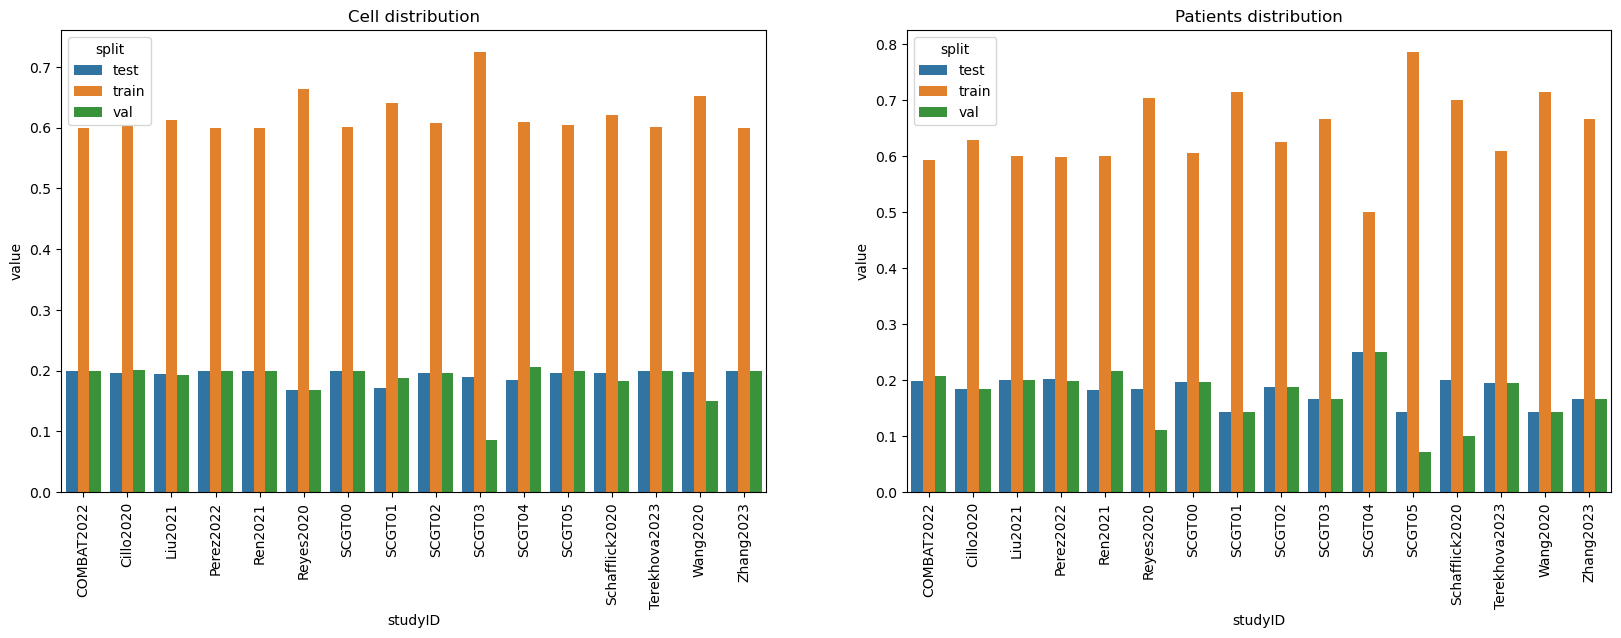

In [14]:
_, axs = plt.subplots(1, 2, figsize=(20, 6))
sns.barplot(x=target_y, y='value', hue='split', data=cell_plot_data, ax=axs[0])
axs[0].set_title('Cell distribution')
axs[0].tick_params(axis='x', labelrotation=90)
sns.barplot(x=target_y, y='value', hue='split', data=pat_plot_data, ax=axs[1])
axs[1].set_title('Patients distribution')
axs[1].tick_params(axis='x', labelrotation=90)

os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/01_split_plots/"), exist_ok=True)

plt.savefig(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/01_split_plots/{RUN_NAME}{CELL_TYPE}_split_quality.pdf'), bbox_inches='tight', dpi=300)

In [15]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/"), exist_ok=True)

np.save(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/{RUN_NAME}{CELL_TYPE}_train_idxs.npy"), train_idxs)
np.save(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/{RUN_NAME}{CELL_TYPE}_val_idxs.npy"), val_idxs)
np.save(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/{RUN_NAME}{CELL_TYPE}_test_idxs.npy"), test_idxs)

### SUBSET DATASET INTO TRAIN/TEST/VAL SPLITS

In [16]:
X_train = adata.X[train_idxs]
X_test = adata.X[test_idxs]
X_val = adata.X[val_idxs]
X_train.shape, X_test.shape, X_val.shape

((478494, 935), (157535, 935), (156926, 935))

In [17]:
y_train = adata.obs.iloc[train_idxs][target_y].values.astype(str)
y_test = adata.obs.iloc[test_idxs][target_y].values.astype(str)
y_val = adata.obs.iloc[val_idxs][target_y].values.astype(str)
y_train.shape, y_test.shape, y_val.shape 

((478494,), (157535,), (156926,))

In [18]:
lenc = LabelEncoder()
y_train_enc = lenc.fit_transform(y_train)
y_val_enc = lenc.transform(y_val)
y_test_enc = lenc.transform(y_test)

### GENERATE F1 

In [19]:
def custom_f1_score(y_true, y_pred):
    return -f1_score(y_true, y_pred.argmax(1), average='weighted')

In [20]:
eval_metric=custom_f1_score
eval_metric_name='custom_f1_score'

def objective(trial):
    params = {
        'sampling_method': 'gradient_based',
        'n_estimators': 1500,
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 250),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.1, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 5e-1, log=True),
    }
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f'validation_0-{eval_metric_name}')
    xgb = xgboost.XGBClassifier(
        device='gpu',
        eval_metric=eval_metric,
        early_stopping_rounds=20,
        callbacks=[pruning_callback],
        **params
    )
    xgb.fit(
        X_train, 
        y_train_enc, 
        verbose=0,
        eval_set=[(X_val, y_val_enc)],
    )
    trial.set_user_attr('best_iteration', xgb.best_iteration)

    return xgb.best_score

In [21]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
wandb_kwargs = {"project": "xgboost", "name": f"{RUN_NAME}{CELL_TYPE}"}
wandbc = optuna.integration.WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)
study.optimize(objective, n_trials=N_TRIALS, callbacks=[wandbc], gc_after_trial=True)

[I 2025-03-18 16:50:50,190] A new study created in memory with name: no-name-197a2eb7-ad43-4f77-b2a0-f0b69a56bec3


/tmp/ipykernel_1709717/350114600.py:4: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandbc = optuna.integration.WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: dav1989 (inflammation) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Tracking run with wandb version 0.19.8


wandb: Run data is saved locally in /scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/03_downstream_analysis/08_gene_importance/wandb/run-20250318_165054-lesrmmip
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run studyID_T_CD4_Naive


wandb: ⭐️ View project at https://wandb.ai/inflammation/xgboost


wandb: 🚀 View run at https://wandb.ai/inflammation/xgboost/runs/lesrmmip


[I 2025-03-18 16:58:25,405] Trial 0 finished with value: -0.975021 and parameters: {'max_depth': 9, 'min_child_weight': 238, 'subsample': 0.7587945476302645, 'colsample_bynode': 0.6387926357773329, 'learning_rate': 0.0026368755339723046}. Best is trial 0 with value: -0.975021.


[I 2025-03-18 16:59:01,754] Trial 1 finished with value: -0.987155 and parameters: {'max_depth': 5, 'min_child_weight': 15, 'subsample': 0.8795585311974417, 'colsample_bynode': 0.6410035105688879, 'learning_rate': 0.08148293210105287}. Best is trial 1 with value: -0.987155.


[I 2025-03-18 16:59:52,427] Trial 2 finished with value: -0.967826 and parameters: {'max_depth': 3, 'min_child_weight': 243, 'subsample': 0.8491983767203796, 'colsample_bynode': 0.29110519961044856, 'learning_rate': 0.003095566460242371}. Best is trial 1 with value: -0.987155.


[I 2025-03-18 17:05:21,821] Trial 3 finished with value: -0.990486 and parameters: {'max_depth': 6, 'min_child_weight': 77, 'subsample': 0.5722807884690141, 'colsample_bynode': 0.48875051677790415, 'learning_rate': 0.006109683510122491}. Best is trial 3 with value: -0.990486.


[I 2025-03-18 17:05:50,106] Trial 4 finished with value: -0.975468 and parameters: {'max_depth': 14, 'min_child_weight': 35, 'subsample': 0.3629301836816964, 'colsample_bynode': 0.4297256589643226, 'learning_rate': 0.01701841881702917}. Best is trial 3 with value: -0.990486.


[I 2025-03-18 17:06:10,398] Trial 5 pruned. Trial was pruned at iteration 24.


[I 2025-03-18 17:06:36,730] Trial 6 finished with value: -0.981884 and parameters: {'max_depth': 13, 'min_child_weight': 43, 'subsample': 0.1585464336867516, 'colsample_bynode': 0.9539969835279999, 'learning_rate': 0.4038423798071558}. Best is trial 3 with value: -0.990486.


[I 2025-03-18 17:06:45,768] Trial 7 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:06:54,724] Trial 8 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:07:03,869] Trial 9 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:07:13,047] Trial 10 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:07:22,539] Trial 11 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:07:32,129] Trial 12 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:08:14,362] Trial 13 finished with value: -0.983857 and parameters: {'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.9946363362670931, 'colsample_bynode': 0.4610357407266027, 'learning_rate': 0.2586083232188041}. Best is trial 3 with value: -0.990486.


[I 2025-03-18 17:08:23,320] Trial 14 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:08:32,527] Trial 15 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:08:42,787] Trial 16 pruned. Trial was pruned at iteration 1.


[I 2025-03-18 17:08:52,428] Trial 17 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:09:01,665] Trial 18 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:09:10,564] Trial 19 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:09:20,456] Trial 20 pruned. Trial was pruned at iteration 1.


[I 2025-03-18 17:09:29,773] Trial 21 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:09:39,240] Trial 22 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:10:12,546] Trial 23 finished with value: -0.989515 and parameters: {'max_depth': 7, 'min_child_weight': 24, 'subsample': 0.7611993489916662, 'colsample_bynode': 0.37025094499418987, 'learning_rate': 0.23044282910430605}. Best is trial 3 with value: -0.990486.


[I 2025-03-18 17:10:21,525] Trial 24 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:11:48,559] Trial 25 finished with value: -0.994945 and parameters: {'max_depth': 4, 'min_child_weight': 27, 'subsample': 0.6803011068210827, 'colsample_bynode': 0.19425481725682284, 'learning_rate': 0.04254104690774154}. Best is trial 25 with value: -0.994945.


[I 2025-03-18 17:11:57,598] Trial 26 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:12:06,801] Trial 27 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:12:15,862] Trial 28 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:12:24,989] Trial 29 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:12:34,330] Trial 30 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:12:43,513] Trial 31 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:12:53,261] Trial 32 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:13:02,834] Trial 33 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:13:13,086] Trial 34 pruned. Trial was pruned at iteration 1.


[I 2025-03-18 17:13:22,483] Trial 35 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:13:32,247] Trial 36 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:13:41,705] Trial 37 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:13:51,257] Trial 38 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:14:00,409] Trial 39 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:14:09,351] Trial 40 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:14:18,522] Trial 41 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:14:27,792] Trial 42 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:15:13,403] Trial 43 finished with value: -0.993847 and parameters: {'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.748821279230953, 'colsample_bynode': 0.5496703593235457, 'learning_rate': 0.1651381289131046}. Best is trial 25 with value: -0.994945.


[I 2025-03-18 17:15:22,284] Trial 44 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:15:31,965] Trial 45 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:15:41,572] Trial 46 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:15:56,366] Trial 47 pruned. Trial was pruned at iteration 13.


[I 2025-03-18 17:16:39,890] Trial 48 finished with value: -0.991784 and parameters: {'max_depth': 10, 'min_child_weight': 41, 'subsample': 0.8376560836443903, 'colsample_bynode': 0.7531253605465777, 'learning_rate': 0.06464760247231187}. Best is trial 25 with value: -0.994945.


[I 2025-03-18 17:16:49,241] Trial 49 pruned. Trial was pruned at iteration 1.


In [22]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/study/"), exist_ok=True)

joblib.dump(study, here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/study/{RUN_NAME}{CELL_TYPE}_xgboost.pkl'))

['/scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/03_downstream_analysis/08_gene_importance/results/targetY_studyID/03_xgboost/study/studyID_T_CD4_Naive_xgboost.pkl']

In [23]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/parallel_coordinate/"), exist_ok=True)

fig = optuna.visualization.plot_parallel_coordinate(study)
fig.write_image(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/parallel_coordinate/{RUN_NAME}{CELL_TYPE}_pcoord.pdf'))

In [24]:
n_estimators = int(study.best_trial.user_attrs['best_iteration']*1.2)
xgb = xgboost.XGBClassifier(
        device='gpu',
        eval_metric=eval_metric,
        n_estimators=n_estimators,
        **study.best_trial.params
    )
xgb.fit(
    ssp.vstack((X_train, X_val)), 
    np.concatenate((y_train_enc, y_val_enc)), 
    eval_set=[(X_test, y_test_enc)],
    verbose=1,
)

[0]	validation_0-mlogloss:2.45565	validation_0-custom_f1_score:-0.95594


[1]	validation_0-mlogloss:2.23252	validation_0-custom_f1_score:-0.96766


[2]	validation_0-mlogloss:2.05338	validation_0-custom_f1_score:-0.97203


[3]	validation_0-mlogloss:1.90470	validation_0-custom_f1_score:-0.97460


[4]	validation_0-mlogloss:1.77571	validation_0-custom_f1_score:-0.97846


[5]	validation_0-mlogloss:1.66357	validation_0-custom_f1_score:-0.97872


[6]	validation_0-mlogloss:1.56280	validation_0-custom_f1_score:-0.98120


[7]	validation_0-mlogloss:1.47281	validation_0-custom_f1_score:-0.98366


[8]	validation_0-mlogloss:1.39272	validation_0-custom_f1_score:-0.98363


[9]	validation_0-mlogloss:1.31830	validation_0-custom_f1_score:-0.98251


[10]	validation_0-mlogloss:1.24943	validation_0-custom_f1_score:-0.98573


[11]	validation_0-mlogloss:1.18630	validation_0-custom_f1_score:-0.98567


[12]	validation_0-mlogloss:1.12755	validation_0-custom_f1_score:-0.98747


[13]	validation_0-mlogloss:1.07315	validation_0-custom_f1_score:-0.98972


[14]	validation_0-mlogloss:1.02275	validation_0-custom_f1_score:-0.99000


[15]	validation_0-mlogloss:0.97497	validation_0-custom_f1_score:-0.98979


[16]	validation_0-mlogloss:0.93071	validation_0-custom_f1_score:-0.98962


[17]	validation_0-mlogloss:0.88814	validation_0-custom_f1_score:-0.99027


[18]	validation_0-mlogloss:0.84864	validation_0-custom_f1_score:-0.99025


[19]	validation_0-mlogloss:0.81137	validation_0-custom_f1_score:-0.99047


[20]	validation_0-mlogloss:0.77553	validation_0-custom_f1_score:-0.99097


[21]	validation_0-mlogloss:0.74198	validation_0-custom_f1_score:-0.99160


[22]	validation_0-mlogloss:0.71009	validation_0-custom_f1_score:-0.99182


[23]	validation_0-mlogloss:0.67976	validation_0-custom_f1_score:-0.99189


[24]	validation_0-mlogloss:0.65144	validation_0-custom_f1_score:-0.99163


[25]	validation_0-mlogloss:0.62405	validation_0-custom_f1_score:-0.99198


[26]	validation_0-mlogloss:0.59816	validation_0-custom_f1_score:-0.99211


[27]	validation_0-mlogloss:0.57365	validation_0-custom_f1_score:-0.99215


[28]	validation_0-mlogloss:0.55037	validation_0-custom_f1_score:-0.99249


[29]	validation_0-mlogloss:0.52785	validation_0-custom_f1_score:-0.99234


[30]	validation_0-mlogloss:0.50660	validation_0-custom_f1_score:-0.99237


[31]	validation_0-mlogloss:0.48656	validation_0-custom_f1_score:-0.99218


[32]	validation_0-mlogloss:0.46702	validation_0-custom_f1_score:-0.99268


[33]	validation_0-mlogloss:0.44875	validation_0-custom_f1_score:-0.99248


[34]	validation_0-mlogloss:0.43099	validation_0-custom_f1_score:-0.99237


[35]	validation_0-mlogloss:0.41403	validation_0-custom_f1_score:-0.99238


[36]	validation_0-mlogloss:0.39780	validation_0-custom_f1_score:-0.99230


[37]	validation_0-mlogloss:0.38233	validation_0-custom_f1_score:-0.99236


[38]	validation_0-mlogloss:0.36746	validation_0-custom_f1_score:-0.99243


[39]	validation_0-mlogloss:0.35309	validation_0-custom_f1_score:-0.99260


[40]	validation_0-mlogloss:0.33957	validation_0-custom_f1_score:-0.99277


[41]	validation_0-mlogloss:0.32664	validation_0-custom_f1_score:-0.99279


[42]	validation_0-mlogloss:0.31416	validation_0-custom_f1_score:-0.99312


[43]	validation_0-mlogloss:0.30226	validation_0-custom_f1_score:-0.99286


[44]	validation_0-mlogloss:0.29120	validation_0-custom_f1_score:-0.99280


[45]	validation_0-mlogloss:0.28032	validation_0-custom_f1_score:-0.99296


[46]	validation_0-mlogloss:0.27010	validation_0-custom_f1_score:-0.99272


[47]	validation_0-mlogloss:0.26027	validation_0-custom_f1_score:-0.99254


[48]	validation_0-mlogloss:0.25068	validation_0-custom_f1_score:-0.99242


[49]	validation_0-mlogloss:0.24137	validation_0-custom_f1_score:-0.99241


[50]	validation_0-mlogloss:0.23271	validation_0-custom_f1_score:-0.99226


[51]	validation_0-mlogloss:0.22444	validation_0-custom_f1_score:-0.99222


[52]	validation_0-mlogloss:0.21615	validation_0-custom_f1_score:-0.99242


[53]	validation_0-mlogloss:0.20812	validation_0-custom_f1_score:-0.99270


[54]	validation_0-mlogloss:0.20046	validation_0-custom_f1_score:-0.99271


[55]	validation_0-mlogloss:0.19353	validation_0-custom_f1_score:-0.99253


[56]	validation_0-mlogloss:0.18655	validation_0-custom_f1_score:-0.99260


[57]	validation_0-mlogloss:0.17981	validation_0-custom_f1_score:-0.99267


[58]	validation_0-mlogloss:0.17332	validation_0-custom_f1_score:-0.99287


[59]	validation_0-mlogloss:0.16714	validation_0-custom_f1_score:-0.99310


[60]	validation_0-mlogloss:0.16117	validation_0-custom_f1_score:-0.99315


[61]	validation_0-mlogloss:0.15560	validation_0-custom_f1_score:-0.99309


[62]	validation_0-mlogloss:0.15022	validation_0-custom_f1_score:-0.99318


[63]	validation_0-mlogloss:0.14496	validation_0-custom_f1_score:-0.99318


[64]	validation_0-mlogloss:0.14001	validation_0-custom_f1_score:-0.99311


[65]	validation_0-mlogloss:0.13514	validation_0-custom_f1_score:-0.99314


[66]	validation_0-mlogloss:0.13047	validation_0-custom_f1_score:-0.99320


[67]	validation_0-mlogloss:0.12610	validation_0-custom_f1_score:-0.99320


[68]	validation_0-mlogloss:0.12176	validation_0-custom_f1_score:-0.99336


[69]	validation_0-mlogloss:0.11755	validation_0-custom_f1_score:-0.99356


[70]	validation_0-mlogloss:0.11373	validation_0-custom_f1_score:-0.99353


[71]	validation_0-mlogloss:0.11007	validation_0-custom_f1_score:-0.99357


[72]	validation_0-mlogloss:0.10629	validation_0-custom_f1_score:-0.99368


[73]	validation_0-mlogloss:0.10283	validation_0-custom_f1_score:-0.99368


[74]	validation_0-mlogloss:0.09953	validation_0-custom_f1_score:-0.99376


[75]	validation_0-mlogloss:0.09622	validation_0-custom_f1_score:-0.99376


[76]	validation_0-mlogloss:0.09309	validation_0-custom_f1_score:-0.99381


[77]	validation_0-mlogloss:0.09014	validation_0-custom_f1_score:-0.99382


[78]	validation_0-mlogloss:0.08723	validation_0-custom_f1_score:-0.99391


[79]	validation_0-mlogloss:0.08449	validation_0-custom_f1_score:-0.99391


[80]	validation_0-mlogloss:0.08189	validation_0-custom_f1_score:-0.99399


[81]	validation_0-mlogloss:0.07933	validation_0-custom_f1_score:-0.99408


[82]	validation_0-mlogloss:0.07685	validation_0-custom_f1_score:-0.99411


[83]	validation_0-mlogloss:0.07465	validation_0-custom_f1_score:-0.99405


[84]	validation_0-mlogloss:0.07237	validation_0-custom_f1_score:-0.99405


[85]	validation_0-mlogloss:0.07017	validation_0-custom_f1_score:-0.99416


[86]	validation_0-mlogloss:0.06790	validation_0-custom_f1_score:-0.99426


[87]	validation_0-mlogloss:0.06599	validation_0-custom_f1_score:-0.99424


[88]	validation_0-mlogloss:0.06386	validation_0-custom_f1_score:-0.99429


[89]	validation_0-mlogloss:0.06211	validation_0-custom_f1_score:-0.99437


[90]	validation_0-mlogloss:0.06033	validation_0-custom_f1_score:-0.99430


[91]	validation_0-mlogloss:0.05867	validation_0-custom_f1_score:-0.99427


[92]	validation_0-mlogloss:0.05701	validation_0-custom_f1_score:-0.99434


[93]	validation_0-mlogloss:0.05554	validation_0-custom_f1_score:-0.99428


[94]	validation_0-mlogloss:0.05401	validation_0-custom_f1_score:-0.99427


[95]	validation_0-mlogloss:0.05253	validation_0-custom_f1_score:-0.99431


[96]	validation_0-mlogloss:0.05117	validation_0-custom_f1_score:-0.99430


[97]	validation_0-mlogloss:0.04973	validation_0-custom_f1_score:-0.99434


[98]	validation_0-mlogloss:0.04833	validation_0-custom_f1_score:-0.99436


[99]	validation_0-mlogloss:0.04725	validation_0-custom_f1_score:-0.99430


[100]	validation_0-mlogloss:0.04606	validation_0-custom_f1_score:-0.99427


[101]	validation_0-mlogloss:0.04493	validation_0-custom_f1_score:-0.99434


[102]	validation_0-mlogloss:0.04392	validation_0-custom_f1_score:-0.99431


[103]	validation_0-mlogloss:0.04278	validation_0-custom_f1_score:-0.99434


[104]	validation_0-mlogloss:0.04175	validation_0-custom_f1_score:-0.99435


[105]	validation_0-mlogloss:0.04075	validation_0-custom_f1_score:-0.99434


[106]	validation_0-mlogloss:0.03980	validation_0-custom_f1_score:-0.99436


[107]	validation_0-mlogloss:0.03896	validation_0-custom_f1_score:-0.99431


[108]	validation_0-mlogloss:0.03818	validation_0-custom_f1_score:-0.99421


[109]	validation_0-mlogloss:0.03730	validation_0-custom_f1_score:-0.99417


[110]	validation_0-mlogloss:0.03652	validation_0-custom_f1_score:-0.99419


[111]	validation_0-mlogloss:0.03578	validation_0-custom_f1_score:-0.99414


[112]	validation_0-mlogloss:0.03488	validation_0-custom_f1_score:-0.99421


[113]	validation_0-mlogloss:0.03405	validation_0-custom_f1_score:-0.99422


[114]	validation_0-mlogloss:0.03348	validation_0-custom_f1_score:-0.99413


[115]	validation_0-mlogloss:0.03293	validation_0-custom_f1_score:-0.99405


[116]	validation_0-mlogloss:0.03219	validation_0-custom_f1_score:-0.99411


[117]	validation_0-mlogloss:0.03162	validation_0-custom_f1_score:-0.99403


[118]	validation_0-mlogloss:0.03095	validation_0-custom_f1_score:-0.99404


[119]	validation_0-mlogloss:0.03039	validation_0-custom_f1_score:-0.99406


[120]	validation_0-mlogloss:0.02977	validation_0-custom_f1_score:-0.99409


[121]	validation_0-mlogloss:0.02924	validation_0-custom_f1_score:-0.99404


[122]	validation_0-mlogloss:0.02869	validation_0-custom_f1_score:-0.99403


[123]	validation_0-mlogloss:0.02823	validation_0-custom_f1_score:-0.99399


[124]	validation_0-mlogloss:0.02779	validation_0-custom_f1_score:-0.99394


[125]	validation_0-mlogloss:0.02738	validation_0-custom_f1_score:-0.99393


[126]	validation_0-mlogloss:0.02684	validation_0-custom_f1_score:-0.99399


[127]	validation_0-mlogloss:0.02642	validation_0-custom_f1_score:-0.99401


[128]	validation_0-mlogloss:0.02589	validation_0-custom_f1_score:-0.99403


[129]	validation_0-mlogloss:0.02545	validation_0-custom_f1_score:-0.99403


[130]	validation_0-mlogloss:0.02500	validation_0-custom_f1_score:-0.99405


[131]	validation_0-mlogloss:0.02468	validation_0-custom_f1_score:-0.99403


[132]	validation_0-mlogloss:0.02430	validation_0-custom_f1_score:-0.99400


[133]	validation_0-mlogloss:0.02399	validation_0-custom_f1_score:-0.99401


[134]	validation_0-mlogloss:0.02359	validation_0-custom_f1_score:-0.99402


[135]	validation_0-mlogloss:0.02319	validation_0-custom_f1_score:-0.99404


[136]	validation_0-mlogloss:0.02297	validation_0-custom_f1_score:-0.99401


[137]	validation_0-mlogloss:0.02272	validation_0-custom_f1_score:-0.99399


[138]	validation_0-mlogloss:0.02235	validation_0-custom_f1_score:-0.99404


[139]	validation_0-mlogloss:0.02206	validation_0-custom_f1_score:-0.99400


[140]	validation_0-mlogloss:0.02178	validation_0-custom_f1_score:-0.99402


[141]	validation_0-mlogloss:0.02151	validation_0-custom_f1_score:-0.99406


[142]	validation_0-mlogloss:0.02120	validation_0-custom_f1_score:-0.99412


[143]	validation_0-mlogloss:0.02093	validation_0-custom_f1_score:-0.99413


[144]	validation_0-mlogloss:0.02073	validation_0-custom_f1_score:-0.99407


[145]	validation_0-mlogloss:0.02046	validation_0-custom_f1_score:-0.99407


[146]	validation_0-mlogloss:0.02023	validation_0-custom_f1_score:-0.99408


[147]	validation_0-mlogloss:0.01997	validation_0-custom_f1_score:-0.99412


[148]	validation_0-mlogloss:0.01974	validation_0-custom_f1_score:-0.99412


[149]	validation_0-mlogloss:0.01946	validation_0-custom_f1_score:-0.99413


[150]	validation_0-mlogloss:0.01926	validation_0-custom_f1_score:-0.99412


[151]	validation_0-mlogloss:0.01904	validation_0-custom_f1_score:-0.99414


[152]	validation_0-mlogloss:0.01874	validation_0-custom_f1_score:-0.99422


[153]	validation_0-mlogloss:0.01857	validation_0-custom_f1_score:-0.99421


[154]	validation_0-mlogloss:0.01841	validation_0-custom_f1_score:-0.99417


[155]	validation_0-mlogloss:0.01825	validation_0-custom_f1_score:-0.99422


[156]	validation_0-mlogloss:0.01808	validation_0-custom_f1_score:-0.99422


[157]	validation_0-mlogloss:0.01791	validation_0-custom_f1_score:-0.99426


[158]	validation_0-mlogloss:0.01773	validation_0-custom_f1_score:-0.99428


[159]	validation_0-mlogloss:0.01757	validation_0-custom_f1_score:-0.99432


[160]	validation_0-mlogloss:0.01746	validation_0-custom_f1_score:-0.99436


[161]	validation_0-mlogloss:0.01719	validation_0-custom_f1_score:-0.99444


[162]	validation_0-mlogloss:0.01710	validation_0-custom_f1_score:-0.99442


[163]	validation_0-mlogloss:0.01693	validation_0-custom_f1_score:-0.99442


[164]	validation_0-mlogloss:0.01681	validation_0-custom_f1_score:-0.99444


[165]	validation_0-mlogloss:0.01673	validation_0-custom_f1_score:-0.99442


[166]	validation_0-mlogloss:0.01659	validation_0-custom_f1_score:-0.99446


[167]	validation_0-mlogloss:0.01651	validation_0-custom_f1_score:-0.99444


[168]	validation_0-mlogloss:0.01638	validation_0-custom_f1_score:-0.99446


[169]	validation_0-mlogloss:0.01633	validation_0-custom_f1_score:-0.99446


[170]	validation_0-mlogloss:0.01626	validation_0-custom_f1_score:-0.99444


[171]	validation_0-mlogloss:0.01618	validation_0-custom_f1_score:-0.99444


[172]	validation_0-mlogloss:0.01601	validation_0-custom_f1_score:-0.99449


[173]	validation_0-mlogloss:0.01590	validation_0-custom_f1_score:-0.99447


[174]	validation_0-mlogloss:0.01586	validation_0-custom_f1_score:-0.99443


[175]	validation_0-mlogloss:0.01586	validation_0-custom_f1_score:-0.99439


[176]	validation_0-mlogloss:0.01577	validation_0-custom_f1_score:-0.99437


[177]	validation_0-mlogloss:0.01565	validation_0-custom_f1_score:-0.99442


[178]	validation_0-mlogloss:0.01557	validation_0-custom_f1_score:-0.99441


[179]	validation_0-mlogloss:0.01548	validation_0-custom_f1_score:-0.99443


[180]	validation_0-mlogloss:0.01539	validation_0-custom_f1_score:-0.99445


[181]	validation_0-mlogloss:0.01534	validation_0-custom_f1_score:-0.99445


[182]	validation_0-mlogloss:0.01526	validation_0-custom_f1_score:-0.99445


[183]	validation_0-mlogloss:0.01530	validation_0-custom_f1_score:-0.99438


[184]	validation_0-mlogloss:0.01525	validation_0-custom_f1_score:-0.99437


[185]	validation_0-mlogloss:0.01515	validation_0-custom_f1_score:-0.99439


[186]	validation_0-mlogloss:0.01511	validation_0-custom_f1_score:-0.99437


[187]	validation_0-mlogloss:0.01503	validation_0-custom_f1_score:-0.99439


[188]	validation_0-mlogloss:0.01498	validation_0-custom_f1_score:-0.99439


[189]	validation_0-mlogloss:0.01498	validation_0-custom_f1_score:-0.99438


[190]	validation_0-mlogloss:0.01485	validation_0-custom_f1_score:-0.99441


[191]	validation_0-mlogloss:0.01482	validation_0-custom_f1_score:-0.99438


[192]	validation_0-mlogloss:0.01467	validation_0-custom_f1_score:-0.99445


[193]	validation_0-mlogloss:0.01465	validation_0-custom_f1_score:-0.99445


[194]	validation_0-mlogloss:0.01455	validation_0-custom_f1_score:-0.99448


[195]	validation_0-mlogloss:0.01442	validation_0-custom_f1_score:-0.99453


[196]	validation_0-mlogloss:0.01436	validation_0-custom_f1_score:-0.99457


[197]	validation_0-mlogloss:0.01437	validation_0-custom_f1_score:-0.99455


[198]	validation_0-mlogloss:0.01439	validation_0-custom_f1_score:-0.99456


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=0.19425481725682284,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False,
              eval_metric=<function custom_f1_score at 0x78b0789fa700>,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.04254104690774154, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=27, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=199, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [25]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/best_model/"), exist_ok=True)

joblib.dump(xgb, (here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/best_model/{RUN_NAME}{CELL_TYPE}_xgb.json')))

['/scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/03_downstream_analysis/08_gene_importance/results/targetY_studyID/03_xgboost/best_model/studyID_T_CD4_Naive_xgb.json']

In [26]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/predictions/"), exist_ok=True)

(pd.DataFrame(np.array((y_test, y_test_enc, xgb.predict(X_test))).T, columns=['y_true', 'y_true_code', 'y_pred'])
 .to_csv(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/predictions/{RUN_NAME}{CELL_TYPE}_pred_test.zip')))
(pd.DataFrame(np.array((y_train, y_train_enc, xgb.predict(X_train))).T, columns=['y_true', 'y_true_code', 'y_pred'])
 .to_csv(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/predictions/{RUN_NAME}{CELL_TYPE}_pred_train.zip')))

/scratch_isilon/groups/singlecell/shared/conda_env/xgboostGPU/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning:

[17:18:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076482591/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.


